In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('fraudcard.csv')
print(pd.Series({"Dataset shape": "{}".format(df.shape)}).to_string())
df.head()

Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
##Feature engineering 
df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
df['Hour'], temp = temp // (60*60), temp % (60*60)
df['Minute'], df['Second'] = temp // 60, temp % 60
df[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()


,Time,Day,Hour,Minute,Second
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,2.0,0.0,0.0,0.0,2.0


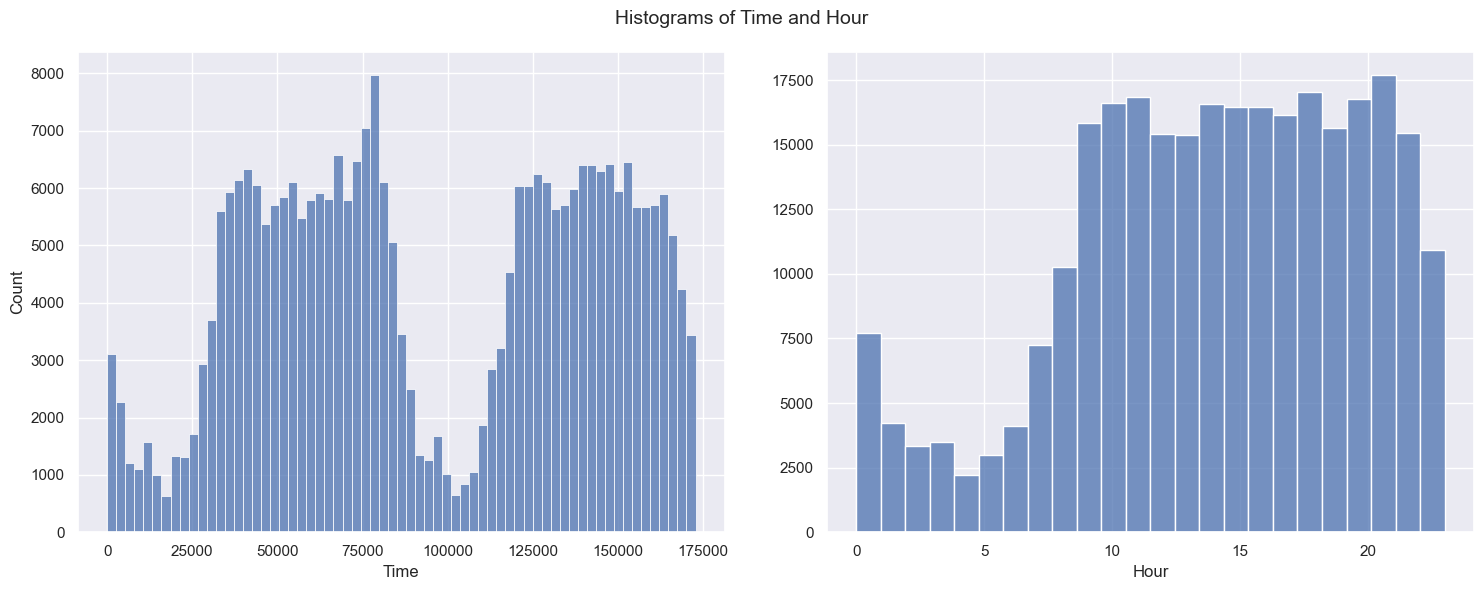

In [4]:
bins_df = math.floor(len(df)**(1/3))
# Visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = df, x = 'Time', bins = bins_df, ax = ax[0])
sns.histplot(data = df, x = 'Hour', bins = 24, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size = 14)
plt.tight_layout()
plt.show()

In [5]:
# Transformation of 'Amount'( small constant (0.001) is added to avoid taking the logarithm of zero or negative values)

df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Day', 'Hour', 'Minute', 'Second', 'Amount_transformed'],
      dtype='object')

# Comparison of feature distributions for different target classes
df_0, df_1 = df[df['Class'] == 0], df[df['Class'] == 1]
cols, ncols = list(df.columns), 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(df_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(df_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

In [9]:
df.drop(['Time','Day','Minute','Second','Amount'],axis=1,inplace=True )

In [10]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Hour',
       'Amount_transformed'],
      dtype='object')

In [16]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Hour,Amount_transformed
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,1.758702e-12,-8.252296e-13,-9.637438e-13,8.316234e-13,1.592013e-13,4.247308e-13,-3.050183e-13,8.692882e-14,-1.179710e-12,7.094921e-13,...,-5.713357e-13,-9.725290e-13,1.464144e-12,-6.989090e-13,-5.615254e-13,3.332111e-12,-3.518885e-12,0.001727,14.046470,1.277733
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,5.835854,0.878875
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-3.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,10.000000,0.748266
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,15.000000,1.342442
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,19.000000,1.887426
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,23.000000,4.409784


In [27]:
from sklearn.model_selection import train_test_split

# Define input and target variables
X = df.iloc[:,:-3]
y = df.iloc[:,-3]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [30]:
#Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [40]:
y_train_resampled[]

0

In [20]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='white')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    Accuracy = tp+tn / (tp + fp+ fn+tn)
    specificity=tn/tn+fp
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision),'\nAccuracy={0:0.3f}'.format(Accuracy),
    '\nSpecificity={0:0.5f}'.format(Specificity))
    print('F1={0:0.3f}'.format(F1))

In [21]:
# Accuracy and auc included
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    Specificity=tn/(tn+fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.5f}'.format(recall),'\nPrecision={0:0.5f}'.format(precision))
    print('F1={0:0.5f}'.format(F1))
    print('Specificity={0:0.5f}'.format(Specificity))
    print('Accuracy={0:0.5f}'.format(accuracy))
    
def plot_aucroc(classifier, scores):
    fpr, tpr, thresholds = roc_curve(y_test, scores, pos_label=1)
    auc = roc_auc_score(y_test, scores)
    
    plt.plot(fpr, tpr, label='AUC = %0.5f' % auc, color="purple")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="best")
    plt.show()

In [22]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [23]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier

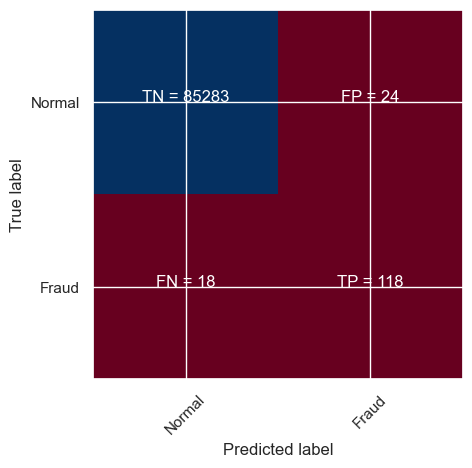

Recall=0.86765 
Precision=0.83099
F1=0.84892
Specificity=0.99972
Accuracy=0.99951
Average precision-recall score: 0.871


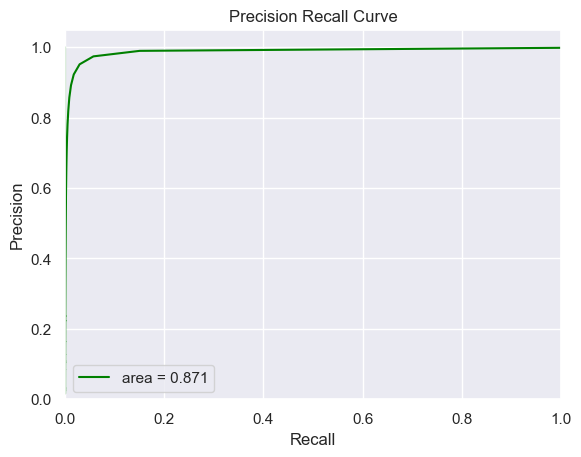

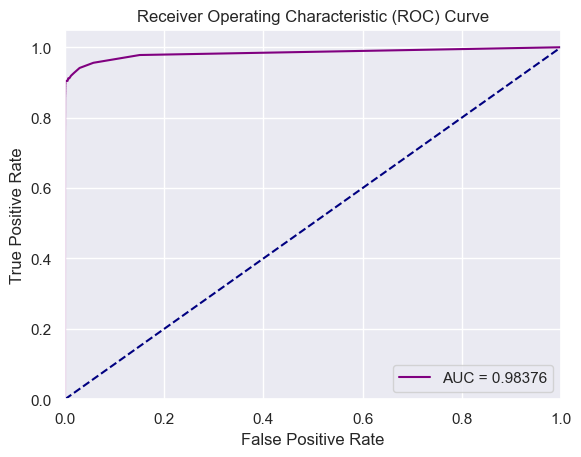

In [32]:
pre = RandomForestClassifier()
pre.fit(X_train_resampled, y_train_resampled)

#Make predictions
y_pred = pre.predict(X_test)
try:
    scores = pre.decision_function(X_test)
except:
    scores = pre.predict_proba(X_test)[:,1]

#Make plots
plot_cm(pre, y_pred)
plot_aucprc(pre, scores)
plot_aucroc(pre, scores)

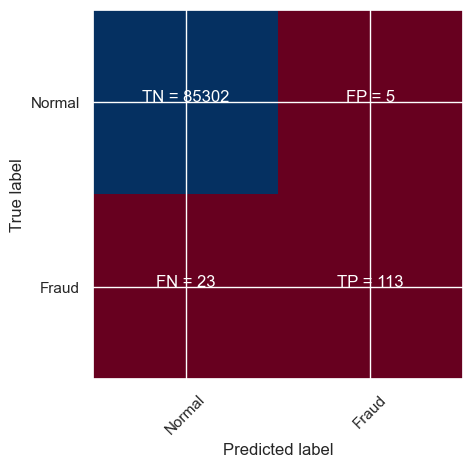

Recall=0.83088 
Precision=0.95763
F1=0.88976
Specificity=0.99994
Accuracy=0.99967
Average precision-recall score: 0.895


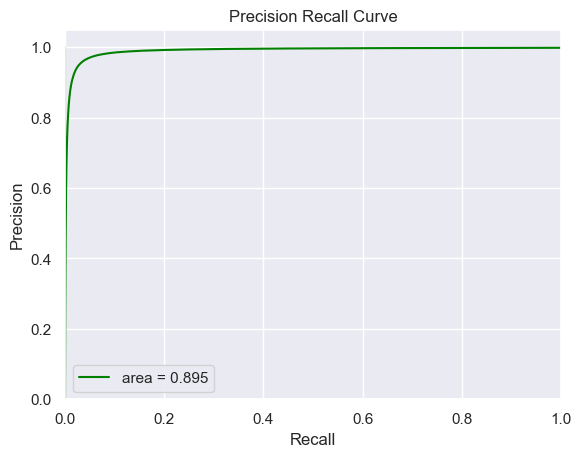

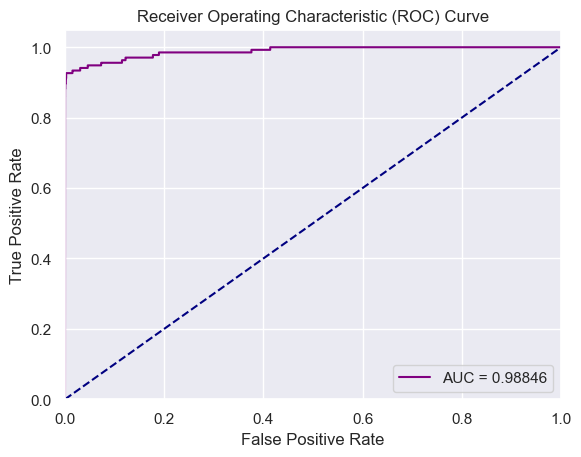

In [33]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

#Make predictions
y_pred = xgb.predict(X_test)
try:
    scores = xgb.decision_function(X_test)
except:
    scores = xgb.predict_proba(X_test)[:,1]
#Make plots
y_pred = xgb.predict(X_test)
plot_cm(xgb, y_pred)
plot_aucprc(xgb, scores)
plot_aucroc(pre, scores)

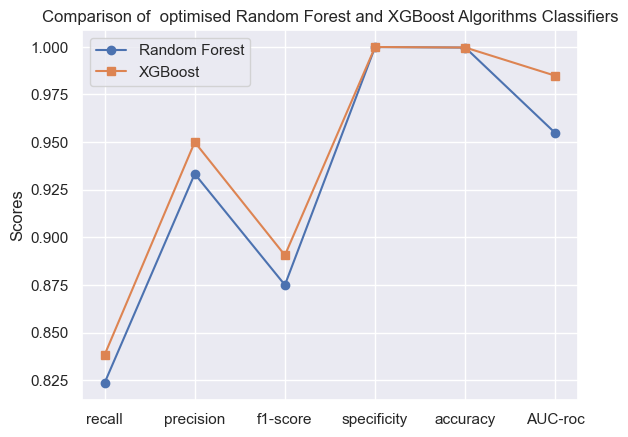

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics and scores
metrics = ['recall', 'precision', 'f1-score', 'specificity', 'accuracy', 'AUC-roc']
rf_scores = [0.82353, 0.93333, 0.875, 0.99991, 0.99963, 0.95467]
xgb_scores = [0.83824, 0.95, 0.89062, 0.99993, 0.99967, 0.98482]

# Define x-axis positions
x = np.arange(len(metrics))

# Create the line graph
fig, ax = plt.subplots()
line_rf = ax.plot(x, rf_scores, marker='o', label='Random Forest')
line_xgb = ax.plot(x, xgb_scores, marker='s', label='XGBoost')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of  optimised Random Forest and XGBoost Algorithms Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the line graph
plt.show()


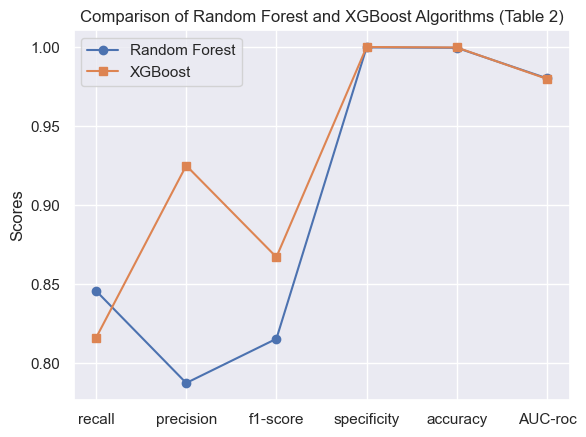

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics and scores
metrics = ['recall', 'precision', 'f1-score', 'specificity', 'accuracy', 'AUC-roc']
rf_scores = [0.84589, 0.78767, 0.8156, 0.99964, 0.99939, 0.98011]
xgb_scores = [0.81618, 0.925, 0.86719, 0.99989, 0.9996, 0.97976]

# Define x-axis positions
x = np.arange(len(metrics))

# Create the line graph
fig, ax = plt.subplots()
line_rf = ax.plot(x, rf_scores, marker='o', label='Random Forest')
line_xgb = ax.plot(x, xgb_scores, marker='s', label='XGBoost')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of Random Forest and XGBoost Algorithms (Table 2)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the line graph
plt.show()


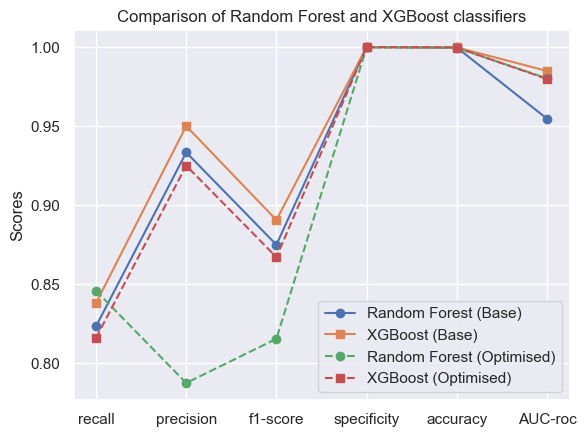

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics and scores
metrics = ['recall', 'precision', 'f1-score', 'specificity', 'accuracy', 'AUC-roc']
rf_scores_table1 = [0.82353, 0.93333, 0.875, 0.99991, 0.99963, 0.95467]
xgb_scores_table1 = [0.83824, 0.95, 0.89062, 0.99993, 0.99967, 0.98482]
rf_scores_table2 = [0.84589, 0.78767, 0.8156, 0.99964, 0.99939, 0.98011]
xgb_scores_table2 = [0.81618, 0.925, 0.86719, 0.99989, 0.9996, 0.97976]

# Define x-axis positions
x = np.arange(len(metrics))

# Create the line graph
fig, ax = plt.subplots()
line_rf_table1 = ax.plot(x, rf_scores_table1, marker='o', linestyle='-', label='Random Forest (Base)')
line_xgb_table1 = ax.plot(x, xgb_scores_table1, marker='s', linestyle='-', label='XGBoost (Base)')
line_rf_table2 = ax.plot(x, rf_scores_table2, marker='o', linestyle='--', label='Random Forest (Optimised)')
line_xgb_table2 = ax.plot(x, xgb_scores_table2, marker='s', linestyle='--', label='XGBoost (Optimised)')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of Random Forest and XGBoost classifiers')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the line graph
plt.show()


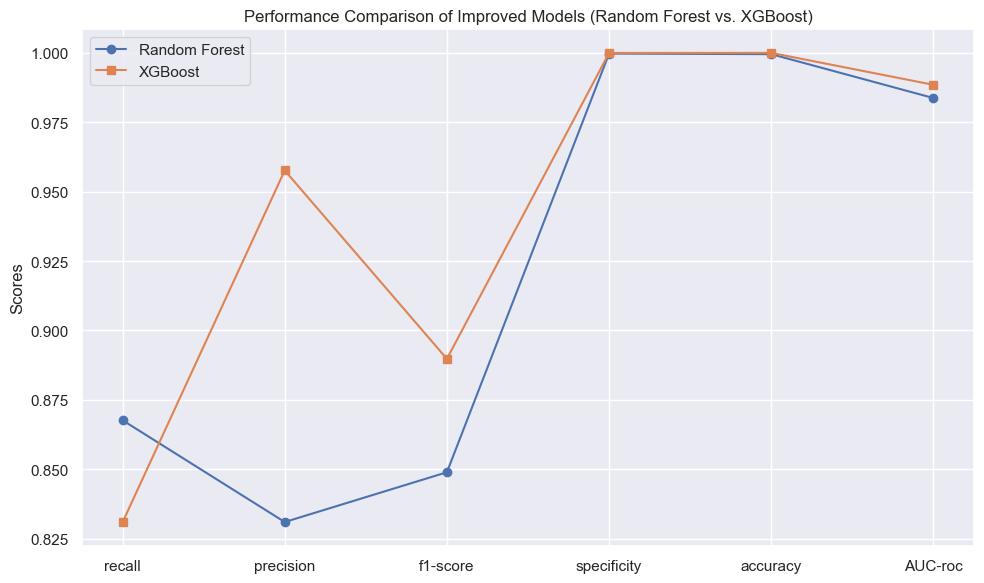

In [35]:
import matplotlib.pyplot as plt

metrics = ['recall', 'precision', 'f1-score', 'specificity', 'accuracy', 'AUC-roc']
rf_values = [0.86765, 0.83099, 0.84892, 0.99972, 0.99951, 0.9837]
xgb_values = [0.83088, 0.95763, 0.88976, 0.99994, 0.999967, 0.98846]

x = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, rf_values, marker='o', label='Random Forest')
ax.plot(x, xgb_values, marker='s', label='XGBoost')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Improved Models (Random Forest vs. XGBoost)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


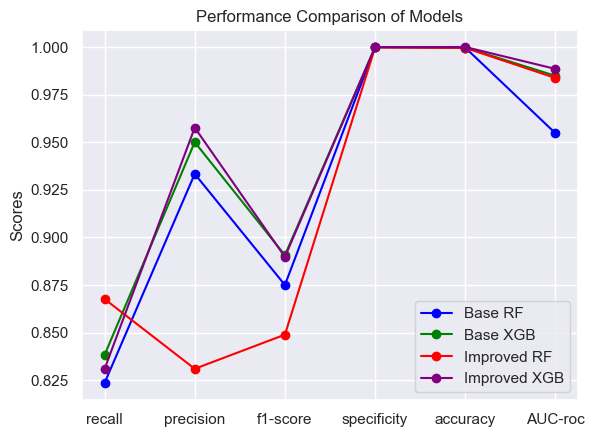

In [38]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['recall', 'precision', 'f1-score', 'specificity', 'accuracy', 'AUC-roc']
base_rf = [0.82353, 0.93333, 0.875, 0.99991, 0.99963, 0.95467]
base_xgb = [0.83824, 0.95, 0.89062, 0.99993, 0.99967, 0.98482]
improved_rf = [0.86765, 0.83099, 0.84892, 0.99972, 0.99951, 0.9837]
improved_xgb = [0.83088, 0.95763, 0.88976, 0.99994, 0.999967, 0.98846]

x = np.arange(len(metrics))

fig, ax = plt.subplots()

ax.plot(metrics, base_rf, marker='o', linestyle='-', label='Base RF', color='blue')
ax.plot(metrics, base_xgb, marker='o', linestyle='-', label='Base XGB', color='green')
ax.plot(metrics, improved_rf, marker='o', linestyle='-', label='Improved RF', color='red')
ax.plot(metrics, improved_xgb, marker='o', linestyle='-', label='Improved XGB', color='purple')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()
